## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [56]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-05-28 21:13:08--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.81.51
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.81.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.3’

train-test-data.zip 100%[===================>] 322.93M  87.6MB/s    in 3.9s    

2020-05-28 21:13:12 (83.8 MB/s) - ‘/data/train-test-data.zip.3’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [57]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

image_size = (224,224)

input_channels = 32

output_channels = 136

n_conv_layers = 4

net = Net(image_size,input_channels,output_channels, n_conv_layers)
print(net)

Net(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm_4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm_5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm_6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [59]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
image_size = (224,224)


data_transform = transforms.Compose([Rescale(256),
                                    RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [60]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())
    


Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [61]:
# load training data in batches
batch_size = 5

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [62]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [63]:
# load test data in batches
batch_size = 5

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [64]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [65]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([5, 1, 224, 224])
torch.Size([5, 68, 2])
torch.Size([5, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [66]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

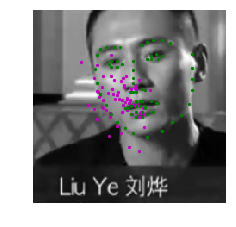

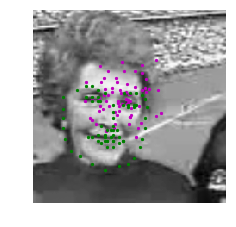

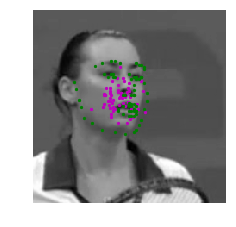

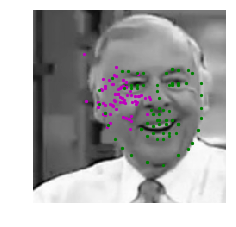

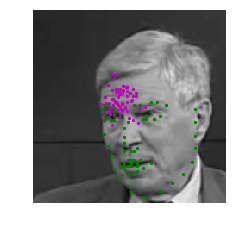

In [67]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=5):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [68]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = torch.optim.Adadelta(net.parameters())

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [69]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    
    training_loss=[]  # my code
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                
                training_loss.append(running_loss) # my_code
                
                running_loss = 0.0
            
    print('Finished Training')
    
    return np.array(training_loss)


In [17]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    training_loss=train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 108.59980819821358
Epoch: 1, Batch: 20, Avg. Loss: 7.455587947368622
Epoch: 1, Batch: 30, Avg. Loss: 5.925229775905609
Epoch: 1, Batch: 40, Avg. Loss: 35.76226944923401
Epoch: 1, Batch: 50, Avg. Loss: 13.200484538078308
Epoch: 1, Batch: 60, Avg. Loss: 23.318046379089356
Epoch: 1, Batch: 70, Avg. Loss: 7.186114490032196
Epoch: 1, Batch: 80, Avg. Loss: 7.144957590103149
Epoch: 1, Batch: 90, Avg. Loss: 8.05999026298523
Epoch: 1, Batch: 100, Avg. Loss: 2.528022754192352
Epoch: 1, Batch: 110, Avg. Loss: 6.556113302707672
Epoch: 1, Batch: 120, Avg. Loss: 3.123557525873184
Epoch: 1, Batch: 130, Avg. Loss: 0.7551597833633423
Epoch: 1, Batch: 140, Avg. Loss: 2.7019773602485655
Epoch: 1, Batch: 150, Avg. Loss: 6.4373831927776335
Epoch: 1, Batch: 160, Avg. Loss: 0.5709604457020759
Epoch: 1, Batch: 170, Avg. Loss: 0.5284555315971374
Epoch: 1, Batch: 180, Avg. Loss: 0.4971420496702194
Epoch: 1, Batch: 190, Avg. Loss: 0.3559794083237648
Epoch: 1, Batch: 200, Avg. Loss

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [23]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([5, 1, 224, 224])
torch.Size([5, 68, 2])
torch.Size([5, 68, 2])


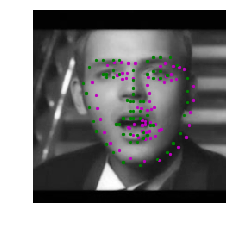

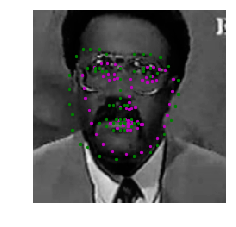

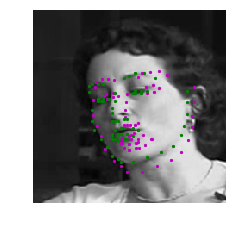

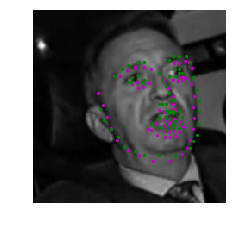

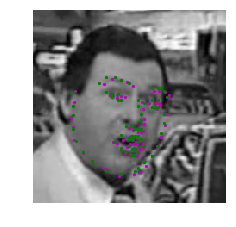

In [73]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


In [24]:
running_loss = 0.0
epoch = 0

for batch_i, data in enumerate(test_loader):
            # get the input images and their corresponding labels
    images = data['image']
    key_pts = data['keypoints']

            # flatten pts
    key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
    key_pts = key_pts.type(torch.FloatTensor)
    images = images.type(torch.FloatTensor)

            # forward pass to get outputs
    output_pts = net(images)

            # calculate the loss between predicted and target keypoints
    loss = criterion(output_pts, key_pts)
    
    running_loss += loss.item()
    if batch_i % 10 == 9:    # print every 10 batches
        print('Epoch: {}, Batch: {}, Avg. Test Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
        running_loss = 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Test Loss: 0.04201694130897522
Epoch: 1, Batch: 20, Avg. Test Loss: 0.0240641207434237
Epoch: 1, Batch: 30, Avg. Test Loss: 0.037573039066046476
Epoch: 1, Batch: 40, Avg. Test Loss: 0.021561439987272023
Epoch: 1, Batch: 50, Avg. Test Loss: 0.02375076888129115
Epoch: 1, Batch: 60, Avg. Test Loss: 0.02537283655256033
Epoch: 1, Batch: 70, Avg. Test Loss: 0.025068347807973623
Epoch: 1, Batch: 80, Avg. Test Loss: 0.02472784658893943
Epoch: 1, Batch: 90, Avg. Test Loss: 0.026150653790682554
Epoch: 1, Batch: 100, Avg. Test Loss: 0.019513728749006986
Epoch: 1, Batch: 110, Avg. Test Loss: 0.06426542010158301
Epoch: 1, Batch: 120, Avg. Test Loss: 0.07712511736899615
Epoch: 1, Batch: 130, Avg. Test Loss: 0.018714791908860207
Epoch: 1, Batch: 140, Avg. Test Loss: 0.02720676874741912
Epoch: 1, Batch: 150, Avg. Test Loss: 0.021742580551654102


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [76]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_best.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


- ADAM,RMSprop and ADAdelta optimizers have been considered.

Keeping the same architecture (4 Convolutional Layers with 32 channels in the first layer and with Batch Normalization) and training for 1 epoch with a batch size of 10, the following results have been obtained:

Adam: lowesr train loss = 0.37 (Batch 340) lowest test loss = 0.38 The loss tends to converge

RMSprop: lowest train loss = 7.03 (Batch 310) The loss highly oscillates

ADAdelta : lowest train loss = 0.203 (Batch 340) lowest test loss = 0.21 The loaa tends to converge

It has been found the ADAdelta is the optimizer which works best so it has been used for furhter steps.

- MSE loss function

The Mean Squared Error (MSE) loss function has been used since the we have a regression problem. MSE is the typical loss function used in regression.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

- Baseline:

I started with a  baseline of 4 convolutional layers with 32 channels in the first layer and batch normalization after each layer. Using the ADAdelta optimizer, a test error averaged around 0.24 is obtained, which is in line with the training error of the last iterations, so overfittin is not happening.

- Less convolutional layers:

I tried to use only 2 convolutional layers instead of 4, and I realize that despite the training loss is more or less the same when using 4 epochs (0.201), the test loss is three times higher, around 0.62. Thus, using 4 convolutional layers is better than using 2.

- More convolutional layers

I tried to add 2 convolutional layers, 6 instead of 4. Compared to the case of 4 convolutional layers, the loss of the last iteration is lower (0.126 compared to 0.203) but the test loss is higher (0.27 compared to 0.21). Thus, using 6 convolutional layers overfits the data compared to the case of using 4 convolutional layers. It should be noted that in all the cases, batch normalization is present. I tried to add a 20% dropout to the 6 layers case to verify if it helps to reduce overfitting and I found that that a test loss araound 0.23 is achieved. Thus, adding dropout helps in reducing overfitting in the case of 6 conv layers. However, compared to the case of 4 convolutional leyers, there is not a remarkable improvement, thus 4 convolutional layers is the final choice, since 4 convolutional layers requires less computational effort.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

- batch_size:

Training on 1 epoch, different values of batch_size have been used. A low batch_size means that the model performs many updates of the weights in one epoch, but in these updates less number of training samples are considered. On the other hand, a higher batch_size means that the model performs less updates in one epoch, but more training samples are considered. In other words, a low batch size results in a smaller step in the gradient descent algorithm so usually more iterations (more epochs) are required to achieve convergence. A high batch size results in a larger step, which could however oversteps the global minima without reaching a convergence. A higher batch_size results also in higher requirement of memory, since more samples are loaded in a batch. A higher batch size also requires more computational time to process the data. A standard value of batch_size is 32 samples, so this values has been investigated as first. I found that both the training and test loss are higher compared to a batch size of 10. Thus, increasing the batch size does not help the model. For this reason, I tried a batch size of 5. I verified that in this case, both the training and test errors get reduced. For this reason I considered a batch_size of 5.

-  epochs:

I train the model for an arbitrary high number of epoch an analyzed the training ag curve to find the optimal number of epochs. The learning curve with zoom in a range of iterations are shown in the figures below. The iteration loss is saved every 10 batches and for 1 epoch 690 iterations are saved. It can be seen that after 300 iterations there is not a remarkable reduction in the loss. Thus, 1 epoch could be enough for training the model. Between 300 iterations and 1000 iterations there is tiny reduction with some peaks and between 1000 and 2000 iteration the loss is more or less constant with some peaks, a little bit above 0.5. After 300 iterations, the loss drop a little bit below 0.5. Such behavior continues for all the iterations corresponding to up epoch 20. 

The test loss associated with a model trained up to 20 epochs give a test loss between 0.02 and 0.04, which is a very good performance. This can be seen by looking at the predicted keypoints in the plotted images.

Text(0.5,0,'Iteration')

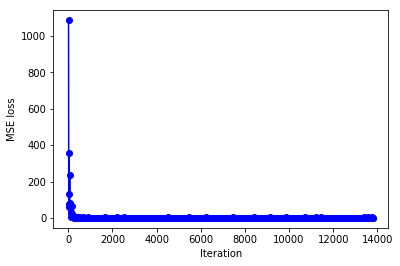

In [77]:
iterations=np.arange(1,len(training_loss)+1)*10
plt.plot(iterations[:],training_loss[:],'bo-')
plt.ylabel('MSE loss')
plt.xlabel('Iteration')

Text(0.5,1,'zoom between iteration 1 and 300')

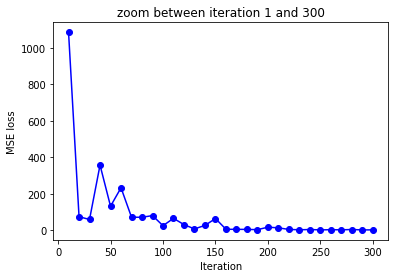

In [78]:
iterations=np.arange(1,len(training_loss)+1)*10
plt.plot(iterations[:30],training_loss[:30],'bo-')
plt.xlabel('Iteration')
plt.ylabel('MSE loss')
plt.title('zoom between iteration 1 and 300')

Text(0.5,1,'zoom between iteration 300 and 1000')

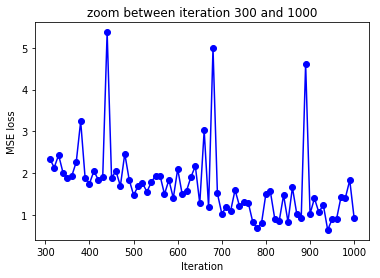

In [79]:
iterations=np.arange(1,len(training_loss)+1)*10
plt.plot(iterations[30:100],training_loss[30:100],'bo-')
plt.xlabel('Iteration')
plt.ylabel('MSE loss')
plt.title('zoom between iteration 300 and 1000')

Text(0.5,1,'zoom between iteration 1000 and 2000')

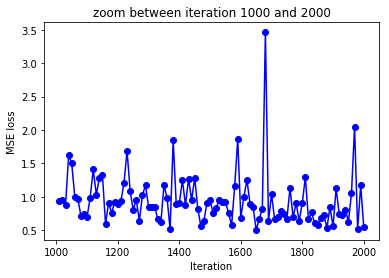

In [80]:
iterations=np.arange(1,len(training_loss)+1)*10
plt.plot(iterations[100:200],training_loss[100:200],'bo-')
plt.xlabel('Iteration')
plt.ylabel('MSE loss') 

plt.title('zoom between iteration 1000 and 2000')

Text(0.5,1,'zoom between iteration 1000 and 2000')

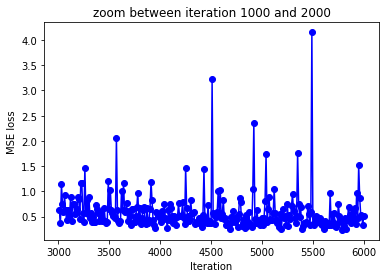

In [81]:
iterations=np.arange(1,len(training_loss)+1)*10
plt.plot(iterations[300:600],training_loss[300:600],'bo-')
plt.xlabel('Iteration')
plt.ylabel('MSE loss')
plt.title('zoom between iteration 1000 and 2000')

Text(0.5,1,'zoom between iteration 1000 and 2000')

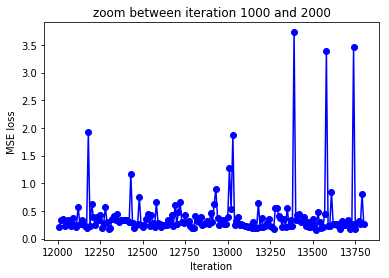

In [82]:
iterations=np.arange(1,len(training_loss)+1)*10
plt.plot(iterations[1200:],training_loss[1200:],'bo-')
plt.xlabel('Iteration')
plt.ylabel('MSE loss')
plt.title('zoom between iteration 1000 and 2000')

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.13556898 -0.04486358  0.18095616]
 [ 0.0958977  -0.24148715  0.17847207]
 [-0.26405895  0.22897276  0.26513967]]
(3, 3)


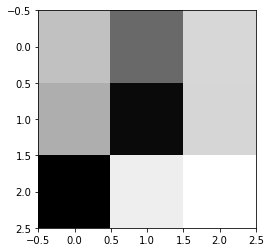

In [15]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv_1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


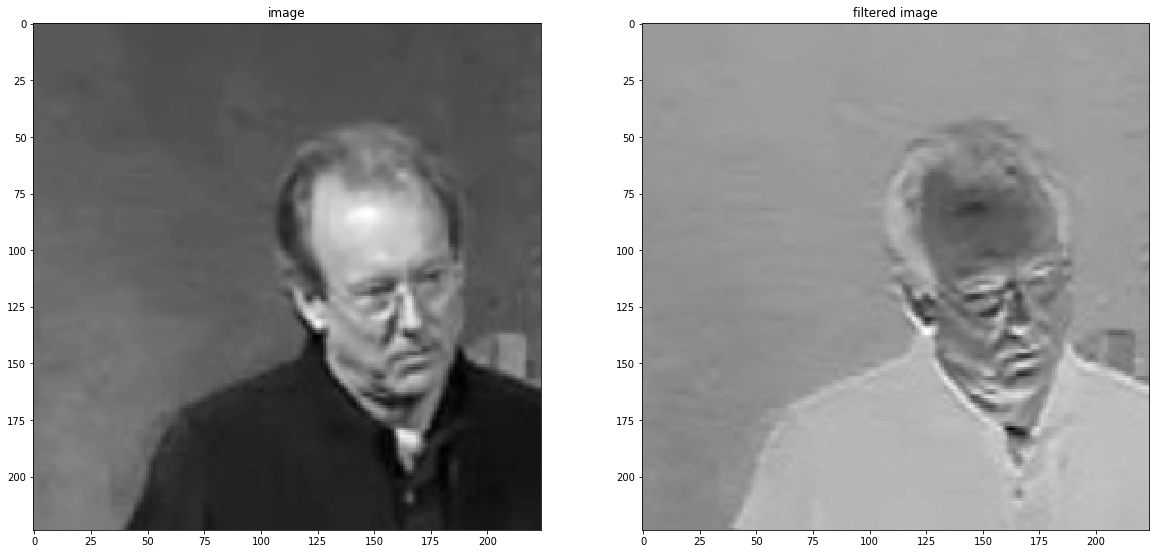

In [43]:
##TODO: load in and display any image from the transformed test dataset

for batch_i, data in enumerate(test_loader):
    images = data['image']

image=images[1,:,:,:].numpy()
    
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

kernel_index=60

kernel=net.conv_2.weight.data.numpy()[kernel_index,0,:,:]

import cv2

filtered_image = cv2.filter2D(image,-1,kernel)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('image')
ax1.imshow(image[0,:,:], cmap='gray')

ax2.set_title('filtered image')
ax2.imshow(filtered_image[0,:,:], cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


The applied filter detects the shadows in the image. For instance, the shadows in the eyes zone or between the cheeks and the nose or between the chin and the neck are highlighted.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!